In [60]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [61]:
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [62]:
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

import numpy as np
import io
import re
from absl import logging

import zipfile
from PIL import Image



Derived, in part, from https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image_classification/cats_vs_dogs.py

Download the zip archive file with the data

In [63]:
_URL = ("https://download.microsoft.com/download/3/E/1/"
        "3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
_NUM_CORRUPT_IMAGES = 1738
_DESCRIPTION = (("A large set of images of cats and dogs. "
                 "There are %d corrupted images that are dropped.") %
                _NUM_CORRUPT_IMAGES)

_NAME_RE = re.compile(r"^PetImages[\\/](Cat|Dog)[\\/]\d+\.jpg$")


In [64]:
download_dir = "/tmpb"
dl_manager = tfds.download.DownloadManager(download_dir=download_dir)
archive_file = dl_manager.download(_URL)

print(f"path: {archive_file}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

path: /tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip


# First solution: Generator

We create a generator
- to read the data from the archive file
- process the data
  - convert the byte string that represents a JPEG image into an image (i.e., 3D array of values)
  - resize all images to a common size

The generator has a number of flags to control its behavior.
It really is more flexible than it needs to be.

In [65]:

def _v0(archive_file, return_obj=False, return_np=True, img_size=(400,400)):
  """
  Generator to return one image at a time, where images are in a zipped archive

  Parameters
  ----------
  archive_file: String.  Path to the zipped archive file
  return_obj: Boolean.  Return the image if True
  return_np:  Boolean.  If return_obj is True,
              then return the imagesas a NumPy ndarray if True
              otherwise return the image as a byte string
  img_size:   Tuple (image width, image height)
              Resize the image to the given dimensions
  """

  # If called from Python: args are type "string"
  # If called from TensorFlow args are bytes (why not Tensor type tf.str, which are bytes ?)
  print(f"Archive file: {type(archive_file)}: {archive_file}")

  if isinstance(archive_file, bytes):
    print(f"Converting archive_file arg from {type(archive_file)} to string")
    archive_file = archive_file.decode()


  archive = zipfile.ZipFile(archive_file, 'r')

  print("Generator Init")
  # Header for a jpg file
  jpg_format = bytes("JFIF", "utf-8")

  # Generator loop: yield one image per iteration
  # - extract one element of the archive at a time
  # -- enumerate names of elements of archive via archive.namelist()
  # -- ignore elements whose names don't match the pattern for example names
  for fname in archive.namelist():
    # Parse the next name in the archive list
    # Skip files whose names don't indicate that it is an example image (e.g., directories)
    res = _NAME_RE.match(fname)
    if not res:  # README file, ...
      continue

    # Extract the byte string that is a JPEG file content
    fobj = archive.read(fname)

    # Skip corrupted files (as per the docs.  Correct name format, but bad content)
    if jpg_format in fobj[:10] not in fobj[:10]:
        num_skipped += 1
        continue

    label = res.group(1).lower()

    # The conversion to JPEG via Image will
    # - work when called by Python
    # - will NOT work when called as a TensorFlow function in non-eager mode
    # -- cannot create a Graph node of Image.open
    # Convert the jpeg byte array, which is variable length, to a NumPy array
    img =  Image.open( io.BytesIO(fobj) )

    print(f"Image type: {img.format}, Original Size: {img.size}")

    # Resize the image so that all images are the same size
    img = img.resize(img_size)
    img_np = np.array(img)

    # Flexible in what is returned
    if return_obj:
      if return_np:
        retval = img_np
      else:
        retval = fobj

      res = (fname, label, retval)
    else:
      res = (fname, label)

    yield res


The generator is a Python function (**not** a Tensorflow Function (`tf.Graph`)
- so can use arbitrary Python code
- when used it TFDS `from_generator`
  - the doc say that the arguments to `from_generator` that are passed to the generator should be Tensors
  - but we will see that these are converted to Python types before making their way to the generator
  - note: Python strings are changed to byte strings
    - A Python string is 1D; a byte string is 0-D (so index into it via array subscripting)
    

In [66]:

def next_example(archive_file, return_obj=False, return_np=True, img_size=(400,400)):
  """
  Generator to return one image at a time, where images are in a zipped archive

  Parameters
  ----------
  archive_file: String or Bytes
    From Python direct: would usually pass a String
    When called from TensorFlow: the argument is a Tensor and "strings" are represented as byte arrays

    The code will convert a byte array argument to a string

  return_obj: Boolean.  Return the image if True
  return_np:  Boolean.  If return_obj is True,
              then return the imagesas a NumPy ndarray if True
              otherwise return the image as a byte string
  img_size:   Tuple (image width, image height)
              Resize the image to the given dimensions
  """

  # Verifyt the argument types
  print(f"Archive file: {type(archive_file)}: {archive_file}, return_obj: {type(return_obj)}: return_obj, return_np: {type(return_np)}")

  if isinstance(archive_file, bytes):
    print(f"Converting archive_file arg from {type(archive_file)} to string")
    archive_file = archive_file.decode()

  archive = zipfile.ZipFile(archive_file, 'r')

  print("Generator Init")

  # Header for a jpg file
  jpg_format = bytes("JFIF", "utf-8")

  # Generator loop: yield one image per iteration
  # - extract one element of the archive at a time
  # -- enumerate names of elements of archive via archive.namelist()
  # -- ignore elements whose names don't match the pattern for example names
  for fname in archive.namelist():
    # Parse the next name in the archive list
    # Skip files whose names don't indicate that it is an example image (e.g., directories)
    res = _NAME_RE.match(fname)
    if not res:  # README file, ...
      continue

    # Extract the byte string that is a JPEG file content
    fobj = archive.read(fname)

    # Skip corrupted files (as per the docs.  Correct name format, but bad content)
    if jpg_format in fobj[:10] not in fobj[:10]:
        num_skipped += 1
        continue

    label = res.group(1).lower()

    # The conversion to JPEG via Image will
    # - work when called by Python
    # - will NOT work when called as a TensorFlow function in non-eager mode
    # -- cannot create a Graph node of Image.open
    # Convert the jpeg byte array, which is variable length, to a NumPy array
    img =  Image.open( io.BytesIO(fobj) )

    print(f"Image type: {img.format}, Original Size: {img.size}")

    # Resize the image so that all images are the same size
    img = img.resize(img_size)
    img_np = np.array(img)

    # Flexible in what is returned
    if return_obj:
      if return_np:
        retval = img_np
      else:
        retval = fobj

      res = (fname, label, retval)
    else:
      res = (fname, label)

    yield res


## Test the generator in plain Python

In [67]:
# Utility function to print output of the generator
def display_gen_result(res):
  if len(res) == 3:
    fname, label, obj = res
    print(f"Name: {fname}, label: {label}, object type: {type(obj)}")
    if isinstance(obj, np.ndarray):
      print(f"Shape: {obj.shape}")
    else:
      print(f"Length: {len(obj)}")
  else:
    fname, label = res
    print(f"Name: {fname}, label: {label}")

**NOTE**

`from_generator` args
- the first arg should be a byte string, not a Python string

In [68]:
gen = next_example(str(archive_file), True, True)

In [69]:
res = next(gen)

display_gen_result(res)




Archive file: <class 'str'>: /tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip, return_obj: <class 'bool'>: return_obj, return_np: <class 'bool'>
Generator Init
Image type: JPEG, Original Size: (500, 375)
Name: PetImages/Cat/0.jpg, label: cat, object type: <class 'numpy.ndarray'>
Shape: (400, 400, 3)


From the output above, notice
- the `archive_file` arg is Python type `bytes`, not `str`
- the type of the returned object is `ndarray` (because we set `return_np = True`)
  - when called via `from_generator`: Tensor will be returned
- the original image size
- the shape of the returned NumPy array has been resized

## Use the generator in `tf.data.Dataset`
- Pass the generator as an argument
- The arguments passed to the generator is a tuple of Tensors
  - per the docs
- Must tell TensorFlow the `output_signature`
  - Output is a tuple of `Tensor`s
    - each element of the tuple is a [`tf.TypeSpec`](https://www.tensorflow.org/api_docs/python/tf/TypeSpec)
    - we set `return_np == True`
      - arguments are positional when called via TFDS, not named as when called from Python
      - since we are asking the image to be returned as an `ndarray` we set the `shape` in the signature to `[None, None, 3]`
        - a 2D image with 3 channels
    - had we set `return_np == False`
      - the image would be returned as a byte string
      - the signature for the byte string would be `tf.TensorSpec(shape=(), dtype=tf.string)`


## Function argument to `from_generator` is  Python function, NOT a TensorFlow Function (`tf.Graph`)
- won't be converted to a `tf.Graph` so can have arbitrary operations
  - e.g., `PIL.Image()` to convert byte array to JPEG image

We can prove it
- Manually: try converting the function to a `tf.Graph` (via `tf.function`) and catch the error

In [70]:
try:
  tf_next_example = tf.function(next_example)
  tf_next_example( archive_file, True, True)
except Exception as e:
  # e = sys.exc_info()[0]
  print("\n\nCouldn't convert `next_example` to a `tf.Graph`: \n\t", e)

Cause: generators are not supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: generators are not supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Couldn't convert `next_example` to a `tf.Graph`: 
	 To be compatible with tf.function, Python functions must return zero or more Tensors or ExtensionTypes or None values; in compilation of <function next_example at 0x7bd484c4c8b0>, found return value of type generator, which is not a Tensor or ExtensionType.


In [71]:
ds_img = tf.data.Dataset.from_generator(next_example, args=( tf.constant(str(archive_file), dtype=tf.string), tf.constant(True, dtype=tf.bool), tf.constant(True, dtype=tf.bool) ),
                                        output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                          tf.TensorSpec(shape=(), dtype=tf.string),
                                                          tf.TensorSpec(shape=[ None, None, 3], dtype=tf.uint8)
                                                          # tf.TensorSpec(shape=(), dtype=tf.string)
                                        ))


## Test the Dataset
- convert to an iterator
- get the first example

In [72]:
import pdb

In [73]:
# Utility to display results
def display_results(results):
  for res in results:
    if len(res) == 3:
      fname, label, obj = res
      print(f"Name: {fname}, label: {label}, object type: {type(obj)}, object Shape: {obj.shape}")

      # Returned objects have the option of being either NumPy ndarray of byte strings
      # The object can either be
      # - a single 3D ndarray: one example that is a 3D image
      # - a 4D ndarray: multiple examples that are each 3D
      # - a 1D ndarray: multiple examples that are byte strings
      # pdb.set_trace()
      if isinstance(obj.numpy(), np.ndarray):
        is_byte_string = False
        if len(obj.shape) == 1:
          is_byte_string = True

        # Object may have a batch dimension, add one just in case
        if (not is_byte_string) and len(obj.shape) == 3:
          obj = obj[ np.newaxis ]

        if not is_byte_string:
          print("\tPeek at the image data: ", obj[:, :5, :5, 0],
                "\n\tNumPy: ",        obj.numpy()[:, :5, :5, 0])
        else:
          print("\nNumPy: Peek at the image data: ")
          for obj_i in obj:
            obj_i_np = obj_i.numpy()
            print(f"\n\t (Length: {len(obj_i_np)}) ", obj_i_np[:10], "\n")
      else:
        # obj is a byte string
        # -- Note: the "length" of a tf.string is NOT an added dimension
        # ----- see https://www.tensorflow.org/guide/tensor#string_tensors
        # ---- so can't "slice" it as [:, :10]. Have to iterate over each row and slice as [:10]
        # Is it a scalar (singleton)
        if len(obj.shape) == 0:
          obj= obj[ np.newaxis ]

        print("\nNumPy: Peek at the image data: ")
        for obj_i in obj:
          obj_i_np = obj_i.numpy()
          print(f"\n\t (Length: {len(obj_i_np)}) ", obj_i_np[:10], "\n")
    else:
      fname, label = res
      print(f"Name: {fname}, label: {label}")

In [74]:
it = iter(ds_img)

result = next(it)

Archive file: <class 'bytes'>: b'/tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip', return_obj: <class 'numpy.bool_'>: return_obj, return_np: <class 'numpy.bool_'>
Converting archive_file arg from <class 'bytes'> to string
Generator Init
Image type: JPEG, Original Size: (500, 375)
Image type: JPEG, Original Size: (300, 281)

In [75]:
display_results( [ result ])

Name: b'PetImages/Cat/0.jpg', label: b'cat', object type: <class 'tensorflow.python.framework.ops.EagerTensor'>, object Shape: (400, 400, 3)
	Peek at the image data:  tf.Tensor(
[[[203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]]], shape=(1, 5, 5), dtype=uint8)
 
	NumPy:  [[[203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]]]


From the output above, notice
- The arguments to the generator were converted from Tensors to plain Python before being passed to the generator
- The `archive_file` argument was passed as a string of `bytes` **NOT** a Python `str`
- The labels, names returned are byte strings, not Python strings
- The type of the image returned is an `EagerTensor` **NOT** a NumPy `ndarray`
  - `from_generator` seems to convert Tensor arguments to NumPy and NumPy results to Tensor
  - When we print the `EagerTensor` it is evaluated and becomes a plain `Tensor`
  - We can convert the `Tensor` to an ndarray with the `.numpy()` method if desired
  - We added a "batch" dimension when displaying the output Tensor
    - it was not there originally
    - we want to make the display code flexible enought to handle batches in the future


Test: enumerate the Dataset by converting to a `list`, rather than manual iteration
- shorten the first Dataset by using `take`
  - otherwise: we will get *all* examples in memory

In [76]:
num_images = 2
results = list(ds_img.take(num_images))

Archive file: <class 'bytes'>: b'/tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip', return_obj: <class 'numpy.bool_'>: return_obj, return_np: <class 'numpy.bool_'>
Converting archive_file arg from <class 'bytes'> to string
Generator Init
Image type: JPEG, Original Size: (500, 375)
Image type: JPEG, Original Size: (300, 281)


Confirm that the number of elements in the returned list is the `num_images`
- that was the parameter to `take`

In [77]:
assert len(results) == num_images

In [78]:
results[0]

(<tf.Tensor: shape=(), dtype=string, numpy=b'PetImages/Cat/0.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>,
 <tf.Tensor: shape=(400, 400, 3), dtype=uint8, numpy=
 array([[[203, 164,  87],
         [203, 164,  87],
         [205, 166,  89],
         ...,
         [241, 202, 123],
         [239, 200, 121],
         [238, 199, 120]],
 
        [[203, 164,  87],
         [203, 164,  87],
         [205, 166,  89],
         ...,
         [241, 202, 123],
         [239, 200, 121],
         [239, 200, 121]],
 
        [[203, 164,  87],
         [203, 164,  87],
         [205, 166,  89],
         ...,
         [241, 202, 123],
         [240, 201, 122],
         [239, 200, 121]],
 
        ...,
 
        [[153, 122,  55],
         [153, 122,  55],
         [153, 122,  55],
         ...,
         [  2,   2,   0],
         [  2,   2,   0],
         [  2,   2,   0]],
 
        [[152, 121,  54],
         [152, 121,  54],
         [153, 122,  55],
         ...,
         [  1,   1,   0],
 

From the output above notice
- the output is a *list* of length `num_images`
- each element of the list is a *tuple* of three components
  - the object (third) componenet is a 3D `Tensor`

In [79]:
display_results(results)


Name: b'PetImages/Cat/0.jpg', label: b'cat', object type: <class 'tensorflow.python.framework.ops.EagerTensor'>, object Shape: (400, 400, 3)
	Peek at the image data:  tf.Tensor(
[[[203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]]], shape=(1, 5, 5), dtype=uint8) 
	NumPy:  [[[203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]]]
Name: b'PetImages/Cat/1.jpg', label: b'cat', object type: <class 'tensorflow.python.framework.ops.EagerTensor'>, object Shape: (400, 400, 3)
	Peek at the image data:  tf.Tensor(
[[[36 37 37 38 38]
  [37 38 38 38 39]
  [39 40 40 40 40]
  [41 41 41 41 41]
  [42 41 41 41 41]]], shape=(1, 5, 5), dtype=uint8) 
	NumPy:  [[[36 37 37 38 38]
  [37 38 38 38 39]
  [39 40 40 40 40]
  [41 41 41 41 41]
  [42 41 41 41 41]]]


## Create a more complex Dataset
- elements are **batches** of examples

In [80]:
batch_size=2
ds_img_batch = ds_img.batch(batch_size).take(10)

In [81]:
it = iter(ds_img_batch)

In [82]:
results = next(it)


Archive file: <class 'bytes'>: b'/tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip', return_obj: <class 'numpy.bool_'>: return_obj, return_np: <class 'numpy.bool_'>
Converting archive_file arg from <class 'bytes'> to string
Generator Init
Image type: JPEG, Original Size: (500, 375)
Image type: JPEG, Original Size: (300, 281)
Image type: JPEG, Original Size: (489, 500)

In [83]:
display_results( [ results ])

Name: [b'PetImages/Cat/0.jpg' b'PetImages/Cat/1.jpg'], label: [b'cat' b'cat'], object type: <class 'tensorflow.python.framework.ops.EagerTensor'>, object Shape: (2, 400, 400, 3)
	Peek at the image data:  tf.Tensor(
[[[203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]]

 [[ 36  37  37  38  38]
  [ 37  38  38  38  39]
  [ 39  40  40  40  40]
  [ 41  41  41  41  41]
  [ 42  41  41  41  41]]], shape=(2, 5, 5), dtype=uint8) 
	NumPy:  [[[203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]
  [203 203 205 207 208]]

 [[ 36  37  37  38  38]
  [ 37  38  38  38  39]
  [ 39  40  40  40  40]
  [ 41  41  41  41  41]
  [ 42  41  41  41  41]]]



Verify that the returned result
- is a tuple
- whose components are Tensors
  - each containing `batch_size` elements

In [84]:
for tuple_elem in results:
  assert tuple_elem.shape[0] == batch_size

Let's display the first image
- the image object is the last element of the tuple
- it is a `Tensor` with `batch_size` elements, so select just one
- convert the `Tensor` to a NumPy `ndarray`

Image type: JPEG, Original Size: (403, 500)


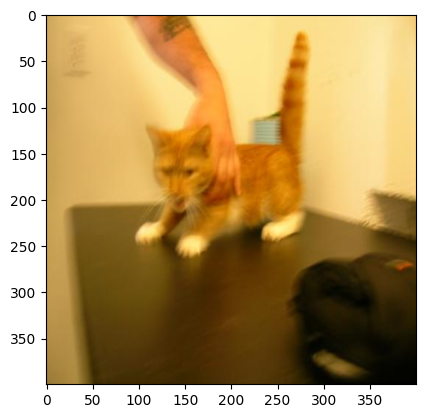

In [85]:
e_img = results[2][0]
plt.imshow(e_img.numpy())


# Second solution: minimal generator, process raw data by chaining TFDS transformations

In [86]:
gen_archive = next_example(str(archive_file), True, False)

In [87]:
res = next(gen_archive)

display_gen_result(res)



Archive file: <class 'str'>: /tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip, return_obj: <class 'bool'>: return_obj, return_np: <class 'bool'>
Generator Init
Image type: JPEG, Original Size: (500, 375)
Name: PetImages/Cat/0.jpg, label: cat, object type: <class 'bytes'>
Length: 12213


From the output above, notice
- the type of the returned object is byte string

## First transformation: transform source into Dataset of byte strings

In [88]:
ds_archive = tf.data.Dataset.from_generator(next_example, args=(tf.constant(str(archive_file), dtype=tf.string), tf.constant(True, dtype=tf.bool), tf.constant(False, dtype=tf.bool) ),
                                                                 output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                                 tf.TensorSpec(shape=(), dtype=tf.string),
                                                                 # tf.TensorSpec(shape=[ None, None, 3], dtype=tf.int16)
                                                                 tf.TensorSpec(shape=(), dtype=tf.string)
                                                         ))


In [89]:
it = iter(ds_archive)

result = next(it)

Archive file: <class 'bytes'>: b'/tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip', return_obj: <class 'numpy.bool_'>: return_obj, return_np: <class 'numpy.bool_'>
Converting archive_file arg from <class 'bytes'> to string
Generator Init
Image type: JPEG, Original Size: (500, 375)
Image type: JPEG, Original Size: (300, 281)


In [90]:
display_results( [ result ])

Name: b'PetImages/Cat/0.jpg', label: b'cat', object type: <class 'tensorflow.python.framework.ops.EagerTensor'>, object Shape: ()

NumPy: Peek at the image data: 

	 (Length: 12213)  b'\xff\xd8\xff\xe0\x00\x10JFIF' 



From the output above, notice
- The type of the image returned is an `EagerTensor`
- The `EagerTensor` is a byte string
  - We added a "batch" dimension when displaying the output Tensor
    - it was not there originally
    - we want to make the display code flexible enought to handle batches in the future


Test: enumerate the Dataset by converting to a `list`, rather than manual iteration
- shorten the Dataset by using `take`

In [91]:
num_images = 2
results = list(ds_archive.take(num_images))

Archive file: <class 'bytes'>: b'/tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip', return_obj: <class 'numpy.bool_'>: return_obj, return_np: <class 'numpy.bool_'>
Converting archive_file arg from <class 'bytes'> to string
Generator Init
Image type: JPEG, Original Size: (500, 375)
Image type: JPEG, Original Size: (300, 281)


Confirm that the number of elements in the returned list is the `num_images`
- that was the parameter to `take`

In [92]:
assert len(results) == num_images

In [93]:
display_results( results )

Name: b'PetImages/Cat/0.jpg', label: b'cat', object type: <class 'tensorflow.python.framework.ops.EagerTensor'>, object Shape: ()

NumPy: Peek at the image data: 

	 (Length: 12213)  b'\xff\xd8\xff\xe0\x00\x10JFIF' 

Name: b'PetImages/Cat/1.jpg', label: b'cat', object type: <class 'tensorflow.python.framework.ops.EagerTensor'>, object Shape: ()

NumPy: Peek at the image data: 

	 (Length: 16868)  b'\xff\xd8\xff\xe0\x00\x10JFIF' 



From the output above, notice
- The length of the byte string varies across examples
  - JPEG images are compressed, so their raw representation as byte strings have variable length
  - when we decode the byte string into an Image, the Image will be 3D but each of the width and height dimensions will vary across images
- A byte string is a scalar 0-D, unlike a `str` which is 1D


## Second transformation: each example is a batch of examples
- elements are **batches** of examples

In [94]:
batch_size=2
ds_archive_batch = ds_archive.batch(batch_size).take(10)

In [95]:
it = iter(ds_archive_batch)

result = next(it)

Archive file: <class 'bytes'>: b'/tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip', return_obj: <class 'numpy.bool_'>: return_obj, return_np: <class 'numpy.bool_'>
Converting archive_file arg from <class 'bytes'> to string
Generator Init
Image type: JPEG, Original Size: (500, 375)
Image type: JPEG, Original Size: (300, 281)


In [96]:
e_name, e_label, e_data = result
print(f"Name shape: {e_name.shape},  Label shape: {e_label.shape}, Data shape: {e_data.shape} (type {type(e_data)}")
print("Names: ", e_name.numpy())
print("Labels: ", e_label.numpy())

Name shape: (2,),  Label shape: (2,), Data shape: (2,) (type <class 'tensorflow.python.framework.ops.EagerTensor'>Image type: JPEG, Original Size: (489, 500)

Names:  [b'PetImages/Cat/0.jpg' b'PetImages/Cat/1.jpg']
Labels:  [b'cat' b'cat']


In [97]:
result

(<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'PetImages/Cat/0.jpg', b'PetImages/Cat/1.jpg'], dtype=object)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'cat', b'cat'], dtype=object)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\xff\xc4\x006\x10\x00\x02\x02\x01\x03\x03\x02\x04\x05\x04\x02\x02\x02\x03\x00\x00\x00\x01\x02\x11\x03\x04\x12!\x051AQa\x06\x13"q\x142R\x81\x91\x15B\xa1\xb1#b\x82\x92\x07\xc14r\xd1\xff\xc4\x00\x1a\x0

Image type: JPEG, Original Size: (403, 500)


Save an image's byte string -- we will use this in a later example

In [98]:
img_byte_string = result[2][0]
img_byte_string

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\xff\xc4\x006\x10\x00\x02\x02\x01\x03\x03\x02\x04\x05\x04\x02\x02\x02\x03\x00\x00\x00\x01\x02\x11\x03\x04\x12!\x051AQa\x06\x13"q\x142R\x81\x91\x15B\xa1\xb1#b\x82\x92\x07\xc14r\xd1\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00$\x11\x01\x01\x00\x02\x02\x02\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x01\x02\x11\x03!\x121\x04\x132AQ"B\

In [99]:
display_results( [ result ] )

Name: [b'PetImages/Cat/0.jpg' b'PetImages/Cat/1.jpg'], label: [b'cat' b'cat'], object type: <class 'tensorflow.python.framework.ops.EagerTensor'>, object Shape: (2,)

NumPy: Peek at the image data: 

	 (Length: 12213)  b'\xff\xd8\xff\xe0\x00\x10JFIF' 


	 (Length: 16868)  b'\xff\xd8\xff\xe0\x00\x10JFIF' 



From the output above, notice
- the result is for a single element of the new (batched) dataset
- a single element is now an **array** of sub-elements
  - one array member per example in the batch
  - the array member corresponding to Name is a byte string
- contrast this to applying `take(2)` to the `ds_archive` Dataset
  - the result is a list of length 2
  - each member of the list is a single example

## Third transformation: each example is a batch of Images (each a 3D `ndarray`) rather than a byte string

Create a function to convert the bytes to NumPy arrays of fixed shape (by resizing the image)


Let's create a function that
- takes an example input
  - name, label, byte string
  - each arg is a `Tensor` because this will be called from TFDS
- converts the byte string (encoded JPEG image) into a JPEG image (3D array)
- re-sizes each image to a constant size
- scales the pixel values to the range [0,1]
- returns a new example
  - name, label, 3D ndarray

In [100]:
import pdb

### Use TensorFlow ops to decode and resize

The function we create will be a TensorFlow Function (as opposed to Python function) that will be turned into a `tf.Graph`

In [101]:
# This function is to be called as a tf.Graph
# - so it should use operations that can be part of a Graph, eg. tf...
# - rather than Python libraries (e.g. PIL.Image)
# -- tf.io.decode
# -- tf.image.resize
def process_img_tf(e_name, e_label, e_data, img_size=[400,400]):
  # No need to extract value of EagerTensor (i.e., apply `.numpy()`)
  # - This function is turned into a `tf.Graph` and args are `Tensor` rather than `EagerTensor`
  print(f"e_name ({type(e_name)}) {e_name}, e_label ({type(e_label)}) {e_label}, e_data ({type(e_data)}): {e_data}")

  # Convert the jpeg byte array, which is variable length, to a NumPy array
  if tf.io.is_jpeg(e_data):
    print("Image raw is JPEG")

  # NOTE: tf.io.decode() does not return "shape" data in the decoded image
  # - use tf.io.decode_jpeg() instead
  img =  tf.io.decode_jpeg(e_data)

  print(f"Image type: {type(img)}")

  # Resize the image so that all images are the same size
  # tf.image.resize requires a "batch" dimension
  img = tf.image.resize( img, img_size)

  # Re-scale pixels to [0,1]
  img = img/255.0

  return e_name, e_label, img


Test `process_img`

In [102]:
it = iter(ds_archive)
example = next(it)

Archive file: <class 'bytes'>: b'/tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip', return_obj: <class 'numpy.bool_'>: return_obj, return_np: <class 'numpy.bool_'>
Converting archive_file arg from <class 'bytes'> to string
Generator Init
Image type: JPEG, Original Size: (500, 375)
Image type: JPEG, Original Size: (300, 281)


In [103]:
e_name, e_label, e_jpg = process_img_tf(*example)

e_name (<class 'tensorflow.python.framework.ops.EagerTensor'>) b'PetImages/Cat/0.jpg', e_label (<class 'tensorflow.python.framework.ops.EagerTensor'>) b'cat', e_data (<class 'tensorflow.python.framework.ops.EagerTensor'>): b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\xff\xc4\x006\x10\x00\x02\x02\x01\x03\x03\x02\x04\x05\x04\x02\x02\x02\x03\x00\x00\x00\x01\x02\x11\x03\x04\x12!\x051AQa\x06\x13"q\x142R\x81\x91\x15B\xa1\xb1#b\x82\x92\x07\xc14r\xd1\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00

In [104]:
e_name, e_label

(<tf.Tensor: shape=(), dtype=string, numpy=b'PetImages/Cat/0.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>)

In [105]:
e_jpg.numpy().shape

(400, 400, 3)

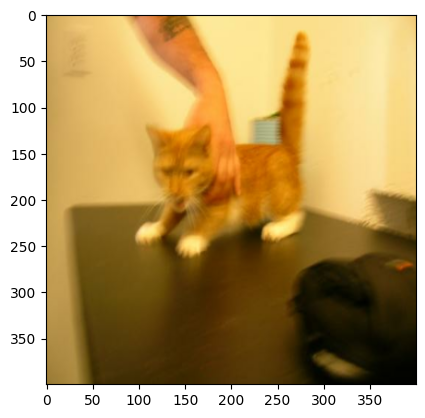

In [106]:

plt.imshow(e_jpg.numpy())


`process_img` seems to work.

Transform the `ds_archive` by applying the function (via `map`) to each element
- resulting in a Dataset whose elements are 3D `ndarray` instead of byte string

In [107]:
ds_img_process = ds_archive.map(process_img_tf)

e_name (<class 'tensorflow.python.framework.ops.SymbolicTensor'>) Tensor("args_0:0", shape=(), dtype=string), e_label (<class 'tensorflow.python.framework.ops.SymbolicTensor'>) Tensor("args_1:0", shape=(), dtype=string), e_data (<class 'tensorflow.python.framework.ops.SymbolicTensor'>): Tensor("args_2:0", shape=(), dtype=string)
Image raw is JPEG
Image type: <class 'tensorflow.python.framework.ops.SymbolicTensor'>


In [108]:
batch_size=2
ds_img_batch_process = ds_archive.map(process_img_tf).batch(batch_size).take(10)

e_name (<class 'tensorflow.python.framework.ops.SymbolicTensor'>) Tensor("args_0:0", shape=(), dtype=string), e_label (<class 'tensorflow.python.framework.ops.SymbolicTensor'>) Tensor("args_1:0", shape=(), dtype=string), e_data (<class 'tensorflow.python.framework.ops.SymbolicTensor'>): Tensor("args_2:0", shape=(), dtype=string)
Image raw is JPEG
Image type: <class 'tensorflow.python.framework.ops.SymbolicTensor'>


In [109]:
it = iter(ds_img_batch_process)

result = next(it)

Archive file: <class 'bytes'>: b'/tmpb/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip', return_obj: <class 'numpy.bool_'>: return_obj, return_np: <class 'numpy.bool_'>
Converting archive_file arg from <class 'bytes'> to string
Generator Init
Image type: JPEG, Original Size: (500, 375)
Image type: JPEG, Original Size: (300, 281)
Image type: JPEG, Original Size: (489, 500)


In [110]:
display_results( [ result ] )

Name: [b'PetImages/Cat/0.jpg' b'PetImages/Cat/1.jpg'], label: [b'cat' b'cat'], object type: <class 'tensorflow.python.framework.ops.EagerTensor'>, object Shape: (2, 400, 400, 3)
Image type: JPEG, Original Size: (403, 500)
	Peek at the image data:  tf.Tensor(
[[[0.7887255  0.79362744 0.7985294  0.8034314  0.80833334]
  [0.7887255  0.79362744 0.7985294  0.8034314  0.80833334]
  [0.7887255  0.79362744 0.7985294  0.8034314  0.80833334]
  [0.7887255  0.79362744 0.7985294  0.8034314  0.80833334]
  [0.7887255  0.79362744 0.7985294  0.8034314  0.80833334]]

 [[0.13725491 0.13725491 0.13872549 0.14166667 0.14460784]
  [0.14159803 0.14159803 0.14306863 0.14573835 0.14705087]
  [0.14811274 0.14811274 0.1492065  0.1509038  0.15015012]
  [0.15637745 0.15637745 0.15643811 0.15606925 0.15324938]
  [0.15686275 0.15686275 0.15589032 0.1537794  0.15083823]]], shape=(2, 5, 5), dtype=float32) 
	NumPy:  [[[0.7887255  0.79362744 0.7985294  0.8034314  0.80833334]
  [0.7887255  0.79362744 0.7985294  0.8034314

Each `result` is a tuple (Name label, Image)
  - members of the tuple are arrays of length `batch_size`

Let's extract the Image (tuple index 2) for each example in the batch

Image type: JPEG, Original Size: (150, 150)
Image type: JPEG, Original Size: (431, 360)
Image type: JPEG, Original Size: (500, 375)
Image type: JPEG, Original Size: (500, 471)


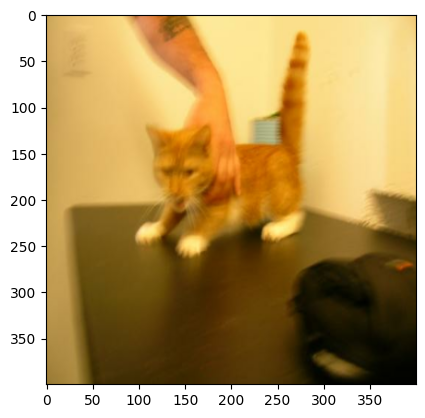

In [111]:
img_0, img_1 = result[2].numpy()[0], result[2].numpy()[1]
plt.imshow(img_0)


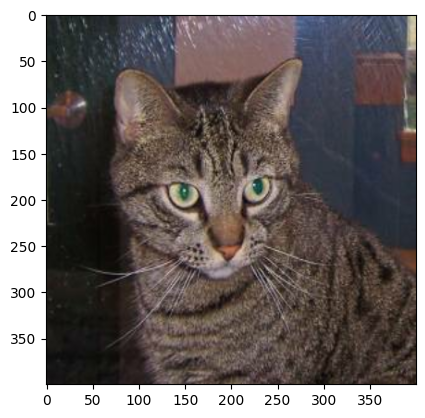

In [112]:
plt.imshow(img_1)

From the above output, notice
- the result is for a single element of the new (batched) dataset
- a single element is now an **array** of sub-elements
  - one sub-element per example in the batch
  - the sub-element per example data's component is a 3D `ndarray`



### What NOT to do

Let's see what happens when the function we create is instead a Python function
- **does not** use TensorFlow ops
  - Uses Python library `io.BytesIO` rather than `tf.io`
  - Uses Python library `PIL.image` rather than `tf.image`


This is an example of what not to do !
- Try pure Python rather than TensorFlow
- Encounter problems with type of arguments and fight it  with complexity !
- Better to understand
  - Debugging in Python (or EagerTensor) and running (via map_ with Tensor is a battle not worth fighting
  - Recognize that Tensor will be argument type and write code that handles Tensor
    - avoid converting EagerTensor as that will only work in debugging

In [113]:
def process_img(e_name, e_label, e_data, img_size=[400,400]):
  print(f"Name: ({type(e_name)} {e_name}, Label: ({type(e_label)} {e_label}, obj ({type(e_data)} {e_data}")

  is_eager = False
  arg_type = str(type(e_name))
  m = re.match(r'.*\.([^\.]+)\'>$', arg_type)
  if m:
    tensor_type = (m.group(1))
    if  tensor_type == "EagerTensor":
      print("Is eager")
      is_eager = True

  # Extract the Numpy from each Tensor
  if is_eager:
    e_name = e_name.numpy()
    e_label = e_label.numpy()
    e_data = e_data.numpy()

  print(f"e_name ({type(e_name)}) {e_name}, e_label ({type(e_label)}) {e_label}, e_data ({type(e_data)}): {e_data}")

  # Convert the jpeg byte array, which is variable length, to a NumPy array
  img_fh = io.BytesIO(e_data)
  img =  Image.open( img_fh )

  print(f"Image type: {img.format}, Original Size: {img.size}")

  # Resize the image so that all images are the same size
  img = img.resize(img_size)

  # Re-scale pixels to [0,1]: Not necessary when using PIL.Image
  # img = img/255.0

  return e_name, e_label, img


In [114]:
new_name, new_label, new_img = process_img( tf.constant("dummy name"), tf.constant("dummy label"), img_byte_string)

Name: (<class 'tensorflow.python.framework.ops.EagerTensor'> b'dummy name', Label: (<class 'tensorflow.python.framework.ops.EagerTensor'> b'dummy label', obj (<class 'tensorflow.python.framework.ops.EagerTensor'> b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\xff\xc4\x006\x10\x00\x02\x02\x01\x03\x03\x02\x04\x05\x04\x02\x02\x02\x03\x00\x00\x00\x01\x02\x11\x03\x04\x12!\x051AQa\x06\x13"q\x142R\x81\x91\x15B\xa1\xb1#b\x82\x92\x07\xc14r\xd1\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x

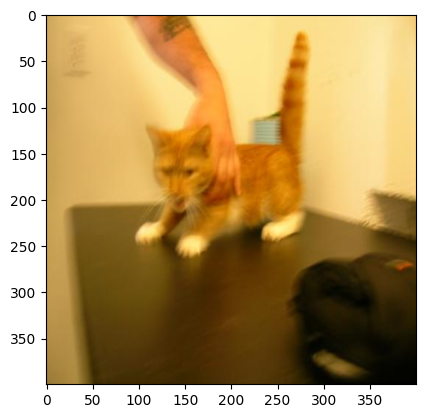

In [115]:
plt.imshow(new_img)

The `process_img` function seems to work !

A couple things to notice:
- The type of each argument is `EagerTensor`
  - This is the type when we executed calls from the command line
  - When called from TensorFlow (e.g., TFDS), the type will be `Tensor`
    - This will be significant later on.
    - In the mean-time: it explains the code's testing the arg type
      - only `EagerTensor` responds to the `.numpy()` method
- We are using Python modules: `io`, `PIL.Image`

Let's apply this function to each element of the Dataset, to create a Dataset whose elements are 3D `ndarray`s instead of byte strings

In [116]:

try:
  ds_img_process_bad = ds_archive.map(process_img)
except Exception as e:
  print("map failed: ", e)


Name: (<class 'tensorflow.python.framework.ops.SymbolicTensor'> Tensor("args_0:0", shape=(), dtype=string), Label: (<class 'tensorflow.python.framework.ops.SymbolicTensor'> Tensor("args_1:0", shape=(), dtype=string), obj (<class 'tensorflow.python.framework.ops.SymbolicTensor'> Tensor("args_2:0", shape=(), dtype=string)
e_name (<class 'tensorflow.python.framework.ops.SymbolicTensor'>) Tensor("args_0:0", shape=(), dtype=string), e_label (<class 'tensorflow.python.framework.ops.SymbolicTensor'>) Tensor("args_1:0", shape=(), dtype=string), e_data (<class 'tensorflow.python.framework.ops.SymbolicTensor'>): Tensor("args_2:0", shape=(), dtype=string)
map failed:  in user code:

    File "<ipython-input-54-293c4e57a4f1>", line 22, in process_img  *
        img_fh = io.BytesIO(e_data)

    TypeError: a bytes-like object is required, not 'SymbolicTensor'



Not working !

Even though we showed that `process_img` works.

What's going on ?

The error message indicates that the `e_data` argument (passed to io.BytesIO) is a `Tensor` rather than a value.

That is a clue.

The `map` function will convert `process_img` to a  `tf.Graph`.

Let's see what happens if we try converting `process_img` to a `tf.Gunction` manually (by using `tf.function`)

In [117]:
try:
  tf_process_img = tf.function(process_img)
  tf_process_img( tf.constant("dummy name"), tf.constant("dummy label"), img_byte_string)
except Exception as e:
  print("\n\nCouldn't convert `process_img` to a `tf.Graph`: \n\t", e)

Name: (<class 'tensorflow.python.framework.ops.SymbolicTensor'> Tensor("e_name:0", shape=(), dtype=string), Label: (<class 'tensorflow.python.framework.ops.SymbolicTensor'> Tensor("e_label:0", shape=(), dtype=string), obj (<class 'tensorflow.python.framework.ops.SymbolicTensor'> Tensor("e_data:0", shape=(), dtype=string)
e_name (<class 'tensorflow.python.framework.ops.SymbolicTensor'>) Tensor("e_name:0", shape=(), dtype=string), e_label (<class 'tensorflow.python.framework.ops.SymbolicTensor'>) Tensor("e_label:0", shape=(), dtype=string), e_data (<class 'tensorflow.python.framework.ops.SymbolicTensor'>): Tensor("e_data:0", shape=(), dtype=string)


Couldn't convert `process_img` to a `tf.Graph`: 
	 in user code:

    File "<ipython-input-54-293c4e57a4f1>", line 22, in process_img  *
        img_fh = io.BytesIO(e_data)

    TypeError: a bytes-like object is required, not 'SymbolicTensor'



So the problem with using `map` is that the conversion of `process_img` to a graph failed.

The graph created describes a computation in terms of graph nodes.
- the graph node represents an operation
- at conversion time: there are no values associated with any graph node that is an input (e.g., the arguments)
- we don't need an actual value to create a graph node
  - e.g., we can create a node to add 2 values, where the values flow from the output of 2 other graph nodes
    - even before these graph nodes have values !
    

The problem is that it is not possible to create a graph node for `io.BytesIO`
- the converter can't create TensorFlow operations for this

The process of turning Python code into a `tf.Graph` is called *tracing*
- It is a bit subtle
- In order to trace a Python function: you must pass actual values as parameters
  - the graph created depends on the type of the arguments

The solution:
- replace `io.BytesIO` (and the rest of the `PIL.Image` operations)
- with native TensorFlow ops


In [118]:
print("Done")

Done
